In [1]:
# Import libraries
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_squared_error as mse

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

In [3]:
O3 = pd.read_csv('data/nycO3.csv')
CO = pd.read_csv('data/nycCO.csv')
NO2 = pd.read_csv('data/nycNO2.csv')
SO2 = pd.read_csv('data/nycSO2.csv')

In [4]:
# Change date columns to datetime and set as index for time series
dflist = [O3, CO, NO2, SO2]

for df in dflist:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index(['Date'], inplace=True)
    print(df.index.dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


In [5]:
display(O3.head(), CO.head(), NO2.head(), SO2.head())

,O3 AQI
Date,
2000-01-01,25
2000-01-02,38
2000-01-03,31
2000-01-04,29
2000-01-05,24


,CO AQI
Date,
2000-01-01,27.0
2000-01-02,36.0
2000-01-03,38.0
2000-01-04,33.0
2000-01-05,22.0


,NO2 AQI
Date,
2000-01-01,38
2000-01-02,54
2000-01-03,47
2000-01-04,52
2000-01-05,42


,SO2 AQI
Date,
2000-01-01,105.0
2000-01-02,79.0
2000-01-03,99.0
2000-01-04,82.0
2000-01-05,43.0


In [6]:
df = pd.merge(O3, CO, how='inner', left_index=True, right_index=True)
df = pd.merge(df, NO2, how='inner', left_index=True, right_index=True)
df = pd.merge(df, SO2, how='inner', left_index=True, right_index=True)

df

,O3 AQI,CO AQI,NO2 AQI,SO2 AQI
Date,,,,
2000-01-01,25,27.0,38,105.0
2000-01-02,38,36.0,54,79.0
2000-01-03,31,38.0,47,99.0
2000-01-04,29,33.0,52,82.0
2000-01-05,24,22.0,42,43.0
...,...,...,...,...
2021-09-26,38,6.0,26,0.0
2021-09-27,50,3.0,22,1.0
2021-09-28,27,3.0,26,1.0


In [7]:
# Creating list of daily AQI per pollutant
dailys = [df['O3 AQI'], df['CO AQI'], df['NO2 AQI'], df['SO2 AQI']]

# Downsampling from days to months
monthlyO3 = df.copy()['O3 AQI'].resample('M').mean()
monthlyCO = df.copy()['CO AQI'].resample('M').mean()
monthlyNO2 = df.copy()['NO2 AQI'].resample('M').mean()
monthlySO2 = df.copy()['SO2 AQI'].resample('M').mean()

# Creating list of monthly AQI per pollutant
monthlys = [monthlyO3, monthlyCO, monthlyNO2, monthlySO2]

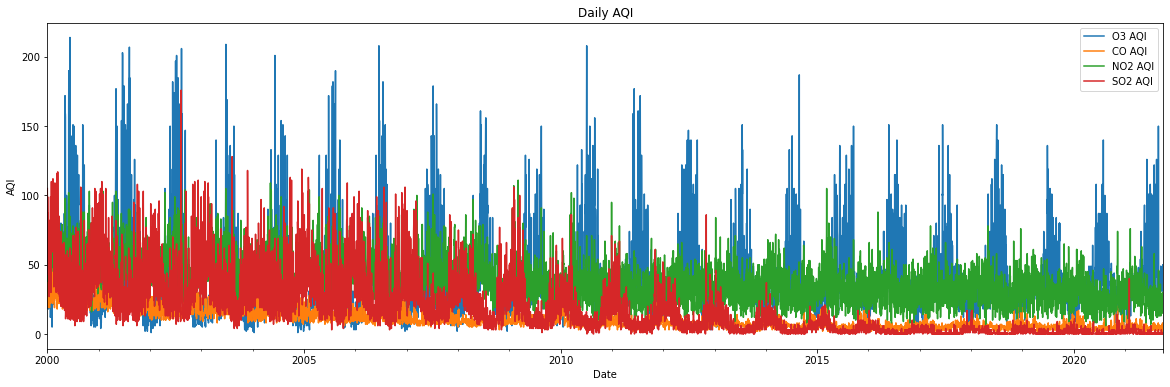

In [28]:
# Plotting daily AQI

for df in dailys:
    df.plot(figsize=(20,6))
    plt.title('Daily AQI')
    plt.ylabel('AQI')
    plt.legend();

In [ ]:
# Plotting daily AQI
for df in dailys:
    df.plot(figsize=(20,6))
    plt.title('Daily AQI')
    plt.legend();

In [ ]:
# Plotting monthly AQI
for df in monthlys:
    df.plot(figsize=(20,6))
    plt.title('Monthly AQI', fontsize=24)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('AQI', fontsize=18)
    plt.legend()
    plt.tight_layout();

In [ ]:
# Plotting monthly AQI
plt.plot(monthlys)
plt.title('Monthly AQI', fontsize=24)
plt.xlabel('Date', fontsize=18)
plt.ylabel('AQI', fontsize=18)
plt.grid(True)
plt.tight_layout();

In [ ]:
# Log
monthlyCO_log = np.log(monthlyCO)
plt.plot(monthlyCO_log)
test_stationarity(monthlyCO_log)

In [ ]:
# Moving average
moving_avg = monthlyCO_log.rolling(window=12).mean()
monthlyCO_log.plot(figsize=(22,2))
moving_avg.plot(color='red')
monthlyCO_log_moving_avg_diff = monthlyCO_log - moving_avg
monthlyCO_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(monthlyCO_log_moving_avg_diff)

In [ ]:
# Eliminating Trend and Seasonality
# First order differencing 
monthlyCO_log_diff = monthlyCO_log - monthlyCO_log.shift()
plt.plot(monthlyCO_log_diff)
monthlyCO_log_diff.dropna(inplace=True)
test_stationarity(monthlyCO_log_diff)

In [ ]:
# Decomposing
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthlyCO_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(monthlyCO_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
monthlyCO_log_decompose = residual
monthlyCO_log_decompose.dropna(inplace=True)
test_stationarity(monthlyCO_log_decompose)

In [ ]:
# ACF and PACF

lag_acf = acf(monthlyCO_log_diff, nlags=20)
lag_pacf = pacf(monthlyCO_log_diff, nlags=20, method='ols')

In [ ]:
#Plot ACF: 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

In [ ]:
#Plot PACF:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [ ]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2],12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(monthlyCO_log,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        
mod = SARIMAX(monthlyCO_log,
              order=(1,0,1),
              seasonal_order=(1, 0, 1, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
monthlyO3_log = np.log(monthlyO3)
monthlyNO2_log = np.log(monthlyNO2)
monthlySO2_log = np.log(monthlySO2)

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-06-30 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
fig = plt.figure(figsize=(22,6))
ax1 = monthlyO3_log['2000':].plot(label='Observed O3')
ax2 = monthlyCO_log['2000':].plot(label='Observed CO')
ax3 = monthlyNO2_log['2000':].plot(label='Observed NO2')
ax4 = monthlySO2_log['2000':].plot(label='Observed SO2')
pred.predicted_mean.plot(ax=ax1, label='One-step Ahead Forecast O3', alpha=.7)
pred.predicted_mean.plot(ax=ax2, label='One-step Ahead Forecast CO', alpha=.7)
pred.predicted_mean.plot(ax=ax3, label='One-step Ahead Forecast NO2', alpha=.7)
pred.predicted_mean.plot(ax=ax4, label='One-step Ahead Forecast SO2', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-06-30 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
fig = plt.figure(figsize=(22,6))
ax = monthlyO3_log['2000':].plot(label='Observed O3')
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Forecast O3', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-06-30 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
fig = plt.figure(figsize=(22,6))
ax = monthlyCO_log['2000':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI Levels')
plt.legend()
plt.show()

In [ ]:
monthlyCO_forecasted = np.exp(pred.predicted_mean)
monthlyCO_truth = np.exp(monthlyCO_log['2015-06-30 00:00:00':])

# Compute the mean square error
mse =( (monthlyCO_forecasted - monthlyCO_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The RMSE of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [ ]:
MASE(monthlyCO_truth, monthlyCO_truth, monthlyCO_forecasted)

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-06-30 00:00:00'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = monthlyCO_log['2000':].plot(label='Observed', figsize=(20, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-06-30 00:00:00'), monthlyCO_log.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show()

In [ ]:
# Extract the predicted and true values of our time series
monthlyCO_forecasted = np.exp(pred_dynamic.predicted_mean)
monthlyCO_truth = np.exp(monthlyCO_log['1998-01-01':])

# Compute the mean square error
mse = ((monthlyCO_forecasted - monthlyCO_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The RMSE of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
MASE(monthlyCO_truth, monthlyCO_truth, monthlyCO_forecasted)

In [ ]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = monthlyCO_log.plot(label='Observed', figsize=(20, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show()


np.exp(pred_uc.predicted_mean)

In [ ]:
for df in dflist:
    df.plot(figsize=(24,2), linewidth=.5, color='#6acfbf');

In [ ]:
for df in dflist:
    df.plot(figsize=(24,2), style='.', ms=2, color='#6acfbf');

In [ ]:
# Determine rolling statistics with a window of 12 months
for df in dflist:
    rmean = df.rolling(window=12, center=False).mean()
    rstd = df.rolling(window=12, center=False).mean()

# Plot rolling statistics against original
for df in dflist:
    fig = plt.figure(figsize=(20,2))
    plt.plot(df, color='#a6a6a6', label='Original')
    plt.plot(rmean, color='blue', linewidth=3, label='Rolling Mean')
    plt.plot(rstd, color='magenta', linewidth=1, label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend();

In [ ]:
# Function to check stationarity
def stationarity_check(ts, name):
    """
    Check stationarity of time series with rolling statistics and Dickey-Fuller test.
    """
    rmean = ts.rolling(window=12, center=False).mean()
    rstd = ts.rolling(window=12, center=False).std()
    dftest = adfuller(ts.iloc[:,0])
    
    # Plot rolling statistics against original
    fig = plt.figure(figsize=(20,4))
    plt.plot(ts, color='gray', label='Original')
    plt.plot(rmean, color='blue', label='Rolling Mean')
    plt.plot(rstd, color='magenta', label='Rolling Std')
    plt.title(f'Rolling Mean & Standard Deviation ({name})')
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '# of Lags Used', '# of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [ ]:
dfliststr = ['O3', 'CO', 'NO2', 'SO2']

In [ ]:
i=0
for df in dflist:
    stationarity_check(df, dfliststr[i])
    i+=1

In [ ]:
def decomposition_plot(ts):
        '''
        Takes time series dataframe and decomposes it
        in order to observe trend, seasonality, and residuals
        '''
        decomp = seasonal_decompose(ts, period=8, model='additive')
        trend = decomp.trend
        seasonal = decomp.seasonal
        residual = decomp.resid
        plt.figure(figsize=(10,7))
        plt.subplot(511)
        plt.plot(ts, label='Observed', color='red')
        plt.legend(loc='best')
        plt.subplot(512)
        plt.plot(trend, label='Trend', color='blue')
        plt.legend(loc='best')
        plt.subplot(513)
        plt.plot(seasonal, label='Seasonality', color='orange')
        plt.legend(loc='best')
        plt.subplot(514)
        plt.plot(residual, label='Residuals', color='black')
        plt.legend(loc='best')
        plt.tight_layout()
        
        return decomp

In [ ]:
for df in dflist:
    decomposition_plot(df)

In [ ]:
def ARMA_model(df, pollutant):

    y = df[f'{pollutant} AQI']
    
    aic_scores = []

    train_size = [len(y),500,250,100,50]

    for p in range(6):
        for q in range(6):
            for size in train_size:
                model = ARIMA(endog = y.tail(size), order =(p,0,q))
                fitmodel = model.fit()
                rmse = np.sqrt(mse(fitmodel))
                aic_scores.append(pd.DataFrame(['ARMA', size, (p,0,q), fitmodel.aic, rmse]).T)
                    
    arma_df = pd.concat(aic_scores, axis = 0)
    arma_df.set_axis(['model type', 'train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    return_df = arma_df.sort_values(['train_size','RMSE'], ascending = [False,True]).reset_index(drop = True)
    
    return return_df

In [ ]:
arma = ARMA_model(O3, 'O3')

In [ ]:
mod_arma = ARMA(O3, order=(1,0), freq='D')
O3_arma = mod_arma.fit()
O3_arma.mse

In [ ]:
# mod_arma = ARMA(O3, order=(1,0), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(0,1), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,0), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(0,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,1), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(1,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arima = ARIMA(O3, order=(1,1,1), freq='D')
# O3_arima = mod_arima.fit()
# print(O3_arima.summary())

# mod_sarimax = SARIMAX(O3, order=(1,1,1), freq='D')
# O3_sarimax = mod_sarimax.fit()
# print(O3_sarimax.summary())